In [58]:
# --- 1. SETUP ---
library(caret)

options(warn = -1) 

set.seed(42)

In [59]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[1] "customer-churn-dataset"

In [60]:
library(caret)
library(rpart)
library(rpart.plot)
library(e1071)
library(randomForest)

In [61]:
list.files("../input/", recursive = TRUE)

[1] "customer-churn-dataset/customer_churn_data.csv"

In [62]:
# --- 2. LOAD & INSPECT ---

df <- read.csv("../input/customer-churn-dataset/customer_churn_data.csv")

In [63]:
print("--- First 6 Rows ---")
head(df)

[1] "--- First 6 Rows ---"


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,⋯,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,CUST0000,Male,0,No,Yes,23,No,No phone service,No,No internet service,⋯,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer,49.85,1146.55,No
2,CUST0001,Female,0,Yes,No,43,No,No phone service,DSL,Yes,⋯,Yes,No,Yes,No,Month-to-month,No,Mailed check,100.70,4330.10,Yes
3,CUST0002,Male,1,No,No,51,Yes,No,DSL,No,⋯,Yes,Yes,No,No,One year,No,Electronic check,97.33,4963.83,Yes
4,CUST0003,Male,1,No,No,72,Yes,Yes,DSL,Yes,⋯,Yes,No,No,No,Month-to-month,No,Credit card,101.38,7299.36,No
5,CUST0004,Male,1,No,No,25,Yes,Yes,DSL,No,⋯,No,Yes,No,Yes,Month-to-month,No,Electronic check,52.22,1305.50,Yes
6,CUST0005,Female,0,Yes,No,35,Yes,No,DSL,No,⋯,No,Yes,Yes,Yes,One year,No,Credit card,116.96,4093.60,No


In [64]:
print("--- Data Structure ---")
str(df)

[1] "--- Data Structure ---"
'data.frame':	5880 obs. of  21 variables:
 $ customerID      : chr  "CUST0000" "CUST0001" "CUST0002" "CUST0003" ...
 $ gender          : chr  "Male" "Female" "Male" "Male" ...
 $ SeniorCitizen   : int  0 0 1 1 1 0 0 0 0 0 ...
 $ Partner         : chr  "No" "Yes" "No" "No" ...
 $ Dependents      : chr  "Yes" "No" "No" "No" ...
 $ tenure          : int  23 43 51 72 25 35 17 18 27 15 ...
 $ PhoneService    : chr  "No" "No" "Yes" "Yes" ...
 $ MultipleLines   : chr  "No phone service" "No phone service" "No" "Yes" ...
 $ InternetService : chr  "No" "DSL" "DSL" "DSL" ...
 $ OnlineSecurity  : chr  "No internet service" "Yes" "No" "Yes" ...
 $ OnlineBackup    : chr  "No internet service" "No" "Yes" "No" ...
 $ DeviceProtection: chr  "No internet service" "Yes" "Yes" "Yes" ...
 $ TechSupport     : chr  "No internet service" "No" "Yes" "No" ...
 $ StreamingTV     : chr  "No internet service" "Yes" "No" "No" ...
 $ StreamingMovies : chr  "No internet service" "No" "No

In [65]:
print("--- Data Summary ---")
summary(df)

[1] "--- Data Summary ---"


  customerID           gender          SeniorCitizen      Partner         
 Length:5880        Length:5880        Min.   :0.0000   Length:5880       
 Class :character   Class :character   1st Qu.:0.0000   Class :character  
 Mode  :character   Mode  :character   Median :1.0000   Mode  :character  
                                       Mean   :0.5007                     
                                       3rd Qu.:1.0000                     
                                       Max.   :1.0000                     
  Dependents            tenure      PhoneService       MultipleLines     
 Length:5880        Min.   : 1.00   Length:5880        Length:5880       
 Class :character   1st Qu.:18.00   Class :character   Class :character  
 Mode  :character   Median :37.00   Mode  :character   Mode  :character  
                    Mean   :36.55                                        
                    3rd Qu.:55.00                                        
                    Max.   :72.

In [66]:
library(ggplot2)

In [67]:
#temporary data cleaning for plotting
df_clean <- df_clean %>%
  mutate_if(is.factor, ~gsub("No internet service", "No", .)) %>%
  mutate_if(is.factor, ~gsub("No phone service", "No", .))

# Convert characters back to factors after gsub
df_clean <- df_clean %>%
  mutate_if(is.character, as.factor)

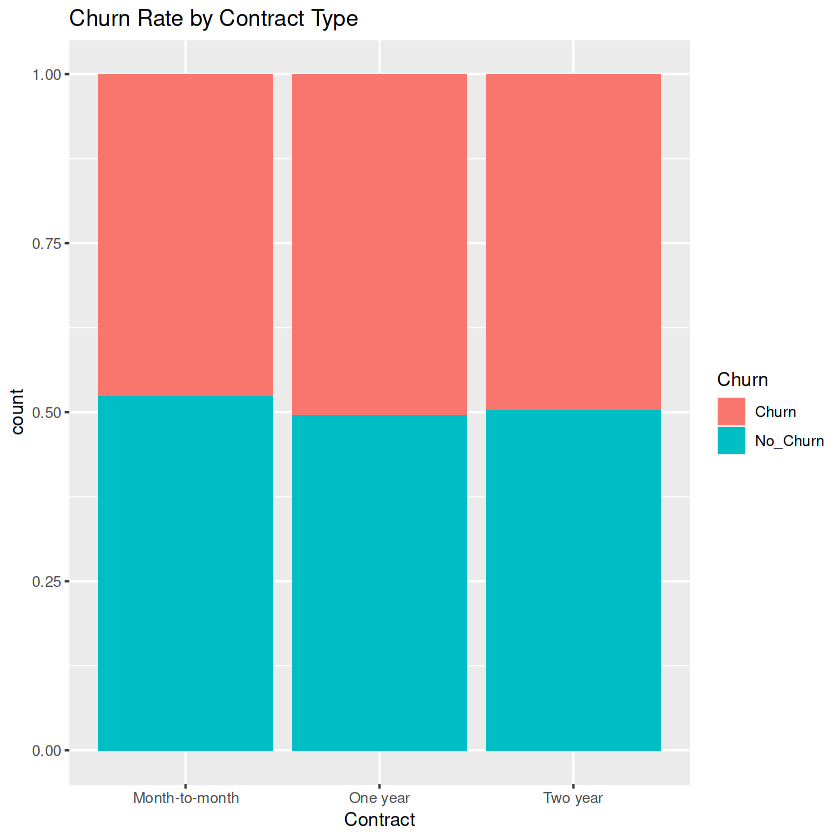

In [68]:
# Churn Rate by Contract Type
ggplot(df_clean, aes(x = Contract, fill = Churn)) +
  geom_bar(position = "fill") +
  ggtitle("Churn Rate by Contract Type")

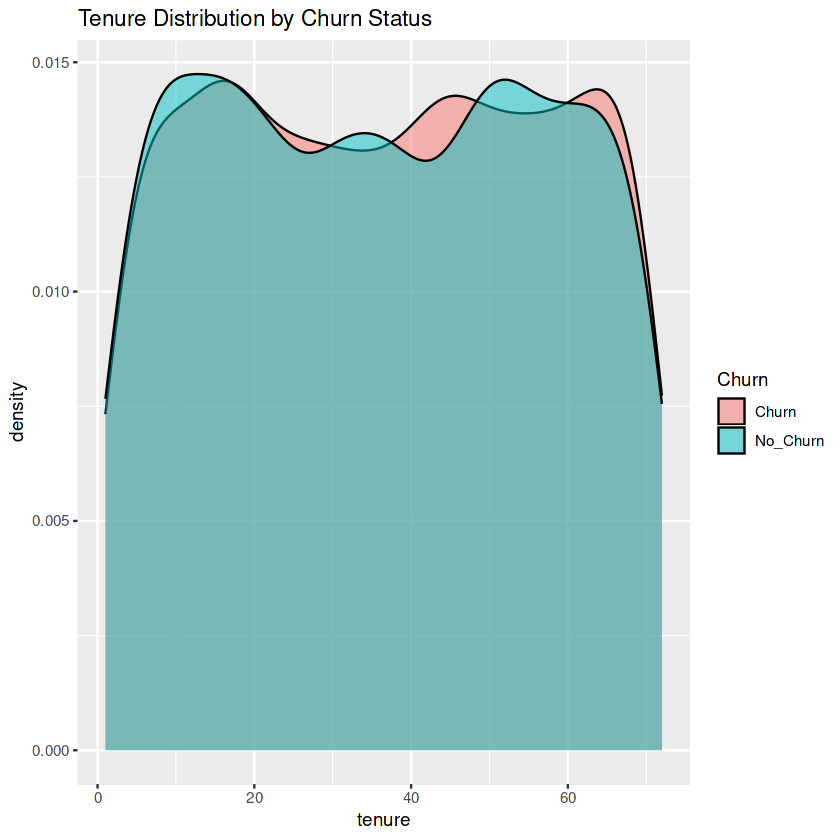

In [69]:
# Tenure Distribution by Churn Status
ggplot(df_clean, aes(x = tenure, fill = Churn)) +
  geom_density(alpha = 0.5) +
  ggtitle("Tenure Distribution by Churn Status")

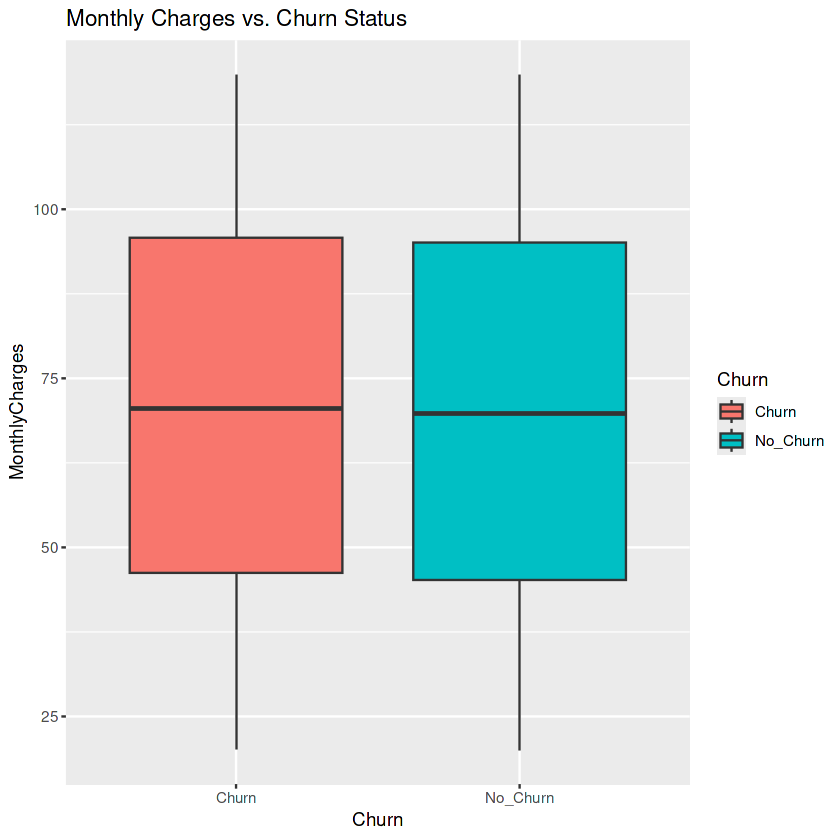

In [70]:
# Monthly Charges by Churn Status
ggplot(df_clean, aes(x = Churn, y = MonthlyCharges, fill = Churn)) +
  geom_boxplot() +
  ggtitle("Monthly Charges vs. Churn Status")

In [71]:
#DATA-CLEANING ---

# Remove customerID using Base R
df_clean <- subset(df, select = -customerID)

# Convert gender to a factor
df_clean$gender <- as.factor(df_clean$gender)

# Convert Churn (0/1) to a factor with meaningful labels
df_clean$Churn <- as.factor(df_clean$Churn)
levels(df_clean$Churn) <- c("No_Churn", "Churn")

print("--- Cleaned Data Structure ---")
str(df_clean)

[1] "--- Cleaned Data Structure ---"
'data.frame':	5880 obs. of  20 variables:
 $ gender          : Factor w/ 2 levels "Female","Male": 2 1 2 2 2 1 2 2 2 1 ...
 $ SeniorCitizen   : int  0 0 1 1 1 0 0 0 0 0 ...
 $ Partner         : chr  "No" "Yes" "No" "No" ...
 $ Dependents      : chr  "Yes" "No" "No" "No" ...
 $ tenure          : int  23 43 51 72 25 35 17 18 27 15 ...
 $ PhoneService    : chr  "No" "No" "Yes" "Yes" ...
 $ MultipleLines   : chr  "No phone service" "No phone service" "No" "Yes" ...
 $ InternetService : chr  "No" "DSL" "DSL" "DSL" ...
 $ OnlineSecurity  : chr  "No internet service" "Yes" "No" "Yes" ...
 $ OnlineBackup    : chr  "No internet service" "No" "Yes" "No" ...
 $ DeviceProtection: chr  "No internet service" "Yes" "Yes" "Yes" ...
 $ TechSupport     : chr  "No internet service" "No" "Yes" "No" ...
 $ StreamingTV     : chr  "No internet service" "Yes" "No" "No" ...
 $ StreamingMovies : chr  "No internet service" "No" "No" "No" ...
 $ Contract        : chr  "Month-t

In [72]:
sum(is.na(df_clean))

[1] 0

In [73]:
# --- 4. DATA SPLITTING ---
sample_index <- sample(1:nrow(df_clean), size = 0.75 * nrow(df_clean))
train_data <- df_clean[sample_index, ]
test_data  <- df_clean[-sample_index, ]

print(paste("Training set size:", nrow(train_data)))
print(paste("Testing set size:", nrow(test_data)))

[1] "Training set size: 4410"
[1] "Testing set size: 1470"


In [74]:
# --- 5. MODEL 1: LOGISTIC REGRESSION ---
print("--- Training Logistic Regression ---")
model_glm <- glm(Churn ~ ., data = train_data, family = "binomial")

# Predict probabilities
prob_glm <- predict(model_glm, newdata = test_data, type = "response")

# Convert probabilities to classes (using 0.5 as cutoff)
pred_glm <- ifelse(prob_glm > 0.5, "Churn", "No_Churn")
pred_glm <- factor(pred_glm, levels = c("No_Churn", "Churn")) # Ensure factor levels match

print("--- Confusion Matrix: Logistic Regression ---")
confusionMatrix(data = pred_glm, reference = test_data$Churn, positive = "Churn")

[1] "--- Training Logistic Regression ---"
[1] "--- Confusion Matrix: Logistic Regression ---"


Confusion Matrix and Statistics

          Reference
Prediction No_Churn Churn
  No_Churn      466   423
  Churn         280   301
                                          
               Accuracy : 0.5218          
                 95% CI : (0.4959, 0.5476)
    No Information Rate : 0.5075          
    P-Value [Acc > NIR] : 0.1424          
                                          
                  Kappa : 0.0405          
                                          
 Mcnemar's Test P-Value : 8.526e-08       
                                          
            Sensitivity : 0.4157          
            Specificity : 0.6247          
         Pos Pred Value : 0.5181          
         Neg Pred Value : 0.5242          
             Prevalence : 0.4925          
         Detection Rate : 0.2048          
   Detection Prevalence : 0.3952          
      Balanced Accuracy : 0.5202          
                                          
       'Positive' Class : Churn           
         

[1] "--- Training Decision Tree ---"
[1] "--- Confusion Matrix: Decision Tree ---"


Confusion Matrix and Statistics

          Reference
Prediction No_Churn Churn
  No_Churn      402   377
  Churn         344   347
                                          
               Accuracy : 0.5095          
                 95% CI : (0.4836, 0.5354)
    No Information Rate : 0.5075          
    P-Value [Acc > NIR] : 0.4482          
                                          
                  Kappa : 0.0182          
                                          
 Mcnemar's Test P-Value : 0.2334          
                                          
            Sensitivity : 0.4793          
            Specificity : 0.5389          
         Pos Pred Value : 0.5022          
         Neg Pred Value : 0.5160          
             Prevalence : 0.4925          
         Detection Rate : 0.2361          
   Detection Prevalence : 0.4701          
      Balanced Accuracy : 0.5091          
                                          
       'Positive' Class : Churn           
         

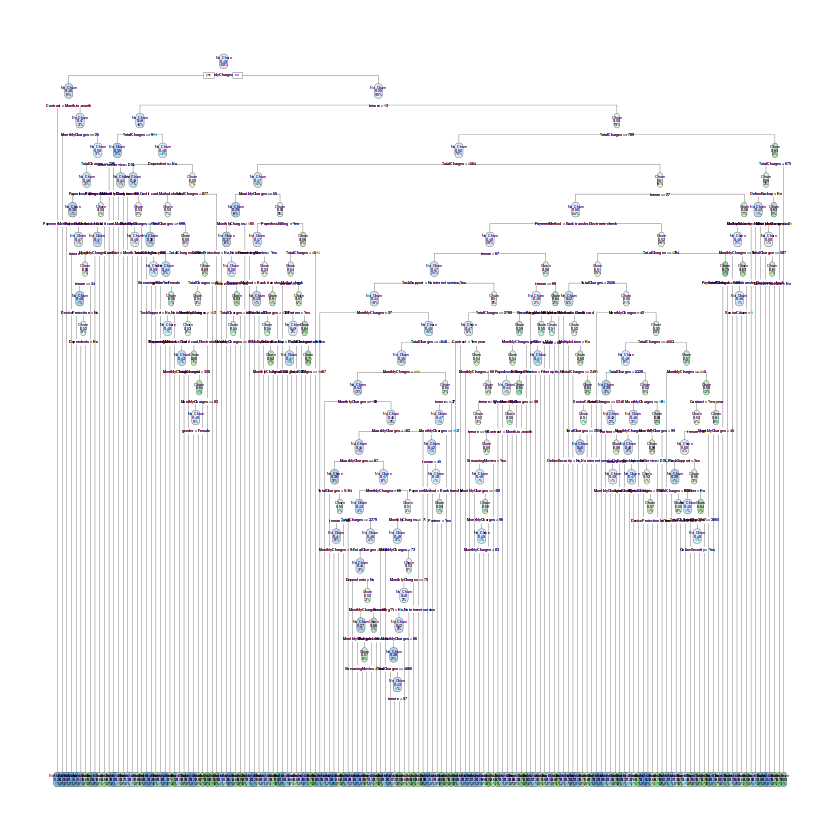

In [75]:
# --- 6. MODEL 2: DECISION TREE ---
print("--- Training Decision Tree ---")

model_tree <- rpart(Churn ~ ., 
                    data = train_data, 
                    method = "class",
                    control = rpart.control(cp = 0.001))

rpart.plot(model_tree)


# Predict classes
pred_tree <- predict(model_tree, newdata = test_data, type = "class")

print("--- Confusion Matrix: Decision Tree ---")
confusionMatrix(data = pred_tree, reference = test_data$Churn, positive = "Churn")

In [76]:
# --- 7. MODEL 3: SUPPORT VECTOR MACHINE (SVM) ---
print("--- Training SVM ---")
model_svm <- svm(Churn ~ ., data = train_data, kernel = "linear")

# Predict classes
pred_svm <- predict(model_svm, newdata = test_data)

print("--- Confusion Matrix: Support Vector Machine ---")
confusionMatrix(data = pred_svm, reference = test_data$Churn, positive = "Churn")

[1] "--- Training SVM ---"
[1] "--- Confusion Matrix: Support Vector Machine ---"


Confusion Matrix and Statistics

          Reference
Prediction No_Churn Churn
  No_Churn      504   485
  Churn         242   239
                                          
               Accuracy : 0.5054          
                 95% CI : (0.4796, 0.5313)
    No Information Rate : 0.5075          
    P-Value [Acc > NIR] : 0.5725          
                                          
                  Kappa : 0.0057          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.3301          
            Specificity : 0.6756          
         Pos Pred Value : 0.4969          
         Neg Pred Value : 0.5096          
             Prevalence : 0.4925          
         Detection Rate : 0.1626          
   Detection Prevalence : 0.3272          
      Balanced Accuracy : 0.5029          
                                          
       'Positive' Class : Churn           
         

In [77]:
# --- 8. MODEL 4: RANDOM FOREST ---
print("--- Training Random Forest ---")
model_rf <- randomForest(Churn ~ ., data = train_data)

# Predict classes
pred_rf <- predict(model_rf, newdata = test_data)

print("--- Confusion Matrix: Random Forest ---")
confusionMatrix(data = pred_rf, reference = test_data$Churn, positive = "Churn")

[1] "--- Training Random Forest ---"
[1] "--- Confusion Matrix: Random Forest ---"


Confusion Matrix and Statistics

          Reference
Prediction No_Churn Churn
  No_Churn      410   374
  Churn         336   350
                                          
               Accuracy : 0.517           
                 95% CI : (0.4911, 0.5428)
    No Information Rate : 0.5075          
    P-Value [Acc > NIR] : 0.2407          
                                          
                  Kappa : 0.033           
                                          
 Mcnemar's Test P-Value : 0.1650          
                                          
            Sensitivity : 0.4834          
            Specificity : 0.5496          
         Pos Pred Value : 0.5102          
         Neg Pred Value : 0.5230          
             Prevalence : 0.4925          
         Detection Rate : 0.2381          
   Detection Prevalence : 0.4667          
      Balanced Accuracy : 0.5165          
                                          
       'Positive' Class : Churn           
         

In [78]:
#Logistic Regression has the highest accuracy 
#Accuracy : 0.5218

In [79]:
# --- 9. MODEL COMPARISON ---

print("--- Generating Comparison Table ---")

# 1. Store all your confusion matrices in variables
cm_glm <- confusionMatrix(data = as.factor(pred_glm), reference = test_data$Churn, positive = "Churn")
cm_tree <- confusionMatrix(data = pred_tree, reference = test_data$Churn, positive = "Churn")
cm_svm <- confusionMatrix(data = pred_svm, reference = test_data$Churn, positive = "Churn")
cm_rf <- confusionMatrix(data = pred_rf, reference = test_data$Churn, positive = "Churn")

# 2. Create vectors of the stats you want to compare
Model <- c("Logistic Regression", 
           "Decision Tree", 
           "Support Vector Machine", 
           "Random Forest")

Accuracy <- c(cm_glm$overall['Accuracy'], 
              cm_tree$overall['Accuracy'], 
              cm_svm$overall['Accuracy'], 
              cm_rf$overall['Accuracy'])


# 3. Combine them into a data frame
results_table <- data.frame(Model, Accuracy)

# 4. Print the final, clean table
print(results_table)

[1] "--- Generating Comparison Table ---"
                   Model  Accuracy
1    Logistic Regression 0.5217687
2          Decision Tree 0.5095238
3 Support Vector Machine 0.5054422
4          Random Forest 0.5170068


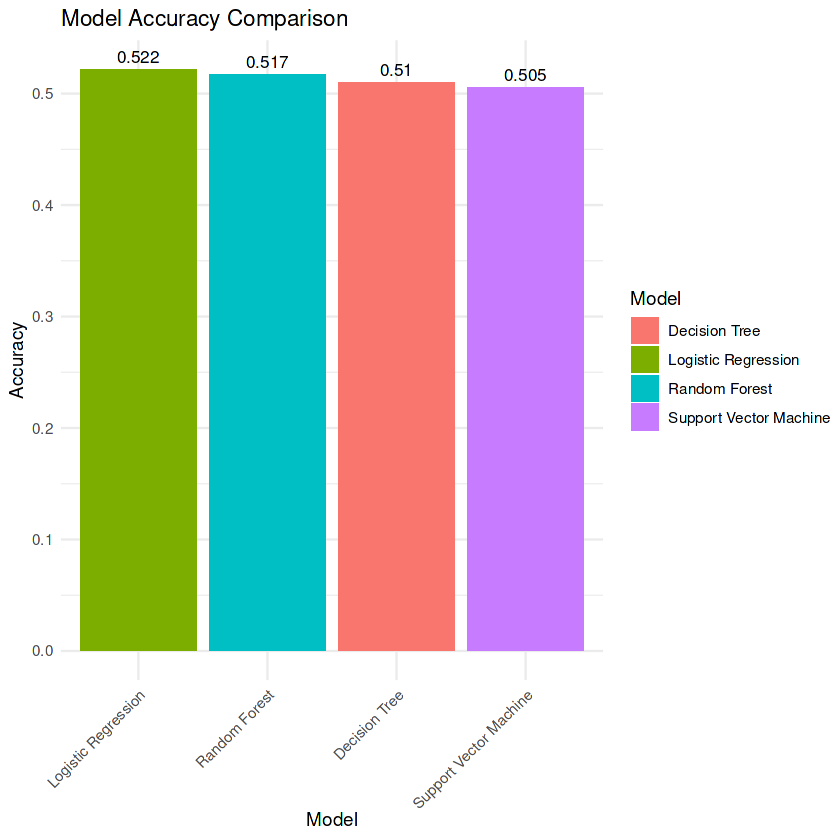

In [80]:
results_table$Accuracy <- as.numeric(results_table$Accuracy)

# Create the bar plot
# reorder(Model, -Accuracy) sorts the bars from highest to lowest accuracy
ggplot(results_table, aes(x = reorder(Model, -Accuracy), y = Accuracy, fill = Model)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = round(Accuracy, 3)), vjust = -0.5, size = 3.5) +
  
  # Set plot titles and labels
  ggtitle("Model Accuracy Comparison") +
  xlab("Model") +
  ylab("Accuracy") +
  
  # Clean up the theme
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) # Angle x-axis labels if they overlap

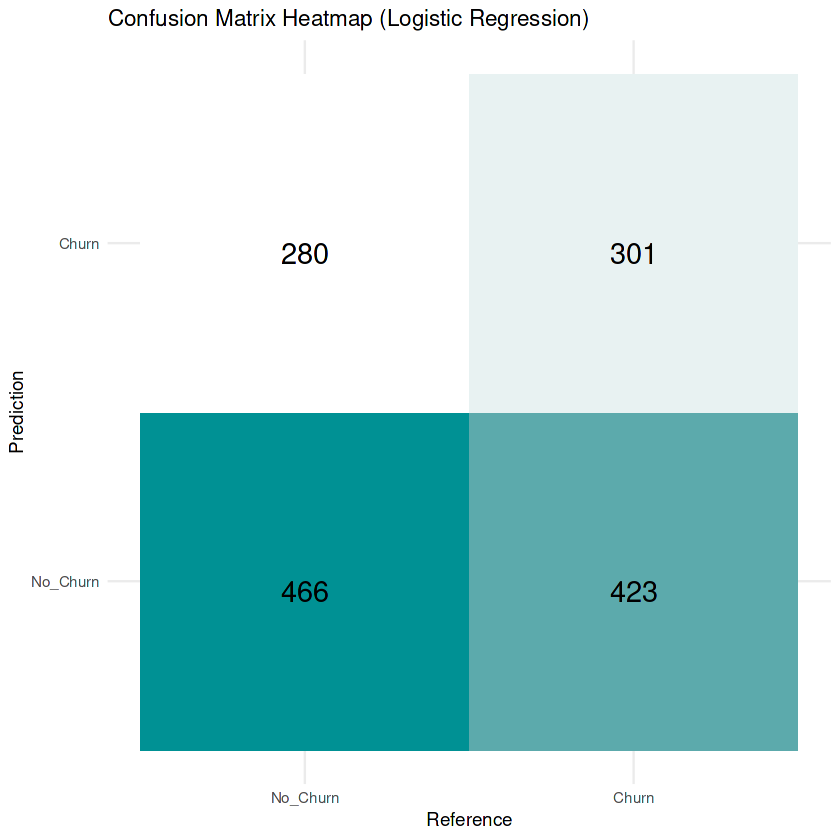

In [81]:
# --- 10. VISUALIZATION: CONFUSION MATRIX HEATMAP ---

# 1. Get the confusion matrix table
cm_table <- cm_glm$table

# 2. Convert it to a data frame
cm_df <- as.data.frame(cm_table)

# 3. Create the heatmap
ggplot(data = cm_df, aes(x = Reference, y = Prediction, fill = Freq)) +
  geom_tile() + # This creates the heatmap
  geom_text(aes(label = Freq), vjust = 1, size = 6) + # Add the counts as text
  scale_fill_gradient(low = "white", high = "#009194") + # Color scale
  ggtitle("Confusion Matrix Heatmap (Logistic Regression)") +
  theme_minimal() +
  theme(legend.position = "none") # Hide the color legend